# Automatic Seismic to Well Tie

#### Import packages

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import yaml

from wtie import grid, autotie, viz
from wtie.utils.datasets import tutorial

from pprint import pprint

import matplotlib.pyplot as plt

# uncomment if your browser supports it
#%matplotlib notebook 

### Import data


In this tutorial we work on data from the Well *Torosa1* of the open [Poseidon](https://terranubis.com/datainfo/NW-Shelf-Australia-Poseidon-3D) dataset. Data is saved in the folder **data/tutorial**.

In [2]:
# data path
folder = Path('../data/tutorial')
assert folder.exists()

inputs = tutorial.load_poseidon_data(folder, well='torosa1')

### Load pretrained network to extract the wavelet

In [3]:
# neural network's weights
model_state_dict = folder / 'trained_net_state_dict.pt'
assert model_state_dict.is_file()

# network training paramters
with open(folder / 'network_parameters.yaml', 'r') as yaml_file:
    training_parameters = yaml.load(yaml_file, Loader=yaml.Loader)
    
wavelet_extractor = tutorial.load_wavelet_extractor(training_parameters, model_state_dict)

Loading network parameters from ../data/tutorial/trained_net_state_dict.pt


### Load synthetic modeling tool

In [4]:
modeler = tutorial.get_modeling_tool()

### Parameters for the search

In [5]:
print(autotie.tie_v1.__doc__)


    Utility to perform automatic (prestack) seismic to well tie. This version 1
    serves as a base recipe. Feel free to implement your own recipe using the
    various tools of the package.

    Parameters
    ----------
    inputs : _tie.InputSet
        Necessary inputs for the well tie.
    wavelet_extractor : wtie.learning.model.BaseEvaluator
        Object to extract a wavelet using the provided neural network.
    modeler : wtie.modeling.modeling.ModelingCallable
        Synthetic modeling tool.
    wavelet_scaling_params : dict
        Parameters for the search of the optimal absolute wavelet sacle.
        3 parameters: 'wavelet_min_scale' and 'wavelet_max_scale' are the search
        bounds. 'num_iters' (optional) is the total number of iterations for the
        search.
    search_space : dict, optional
        Bounds of the search space. See `get_default_search_space_v1`.
    search_params : dict, optional
        Dict with 3 parameters for the Bayesian search. 'num_iter

#### Define the tie parameters search space (optional)

So far, supported parameters correspond to the log filtering and depth to time table bulk shift. See the `tie.get_default_search_space_v1` docstring.

In [6]:
print(autotie.get_default_search_space_v1.__doc__)


    Search space of version 1 is composed of 4 parameters:
        - "logs_median_size" : size (in number of samples) of the median filter window.
        - "logs_median_threshold" : threshold value with respect to the logs standard deviation.
        - "logs_std" : standard deviation of the gaussian smoothing filter.
        - "table_t_shift" : bulk shift in seconds of the depth-time relation table.

    Parameters are defined following the [Ax](https://github.com/facebook/Ax)
    documentation.


In [7]:

# Logs processing
median_length_choice = dict(name="logs_median_size", type="choice",
                  values=[i for i in range(11,63,2)], value_type="int")

median_th_choice = dict(name="logs_median_threshold", type="range",
                  bounds=[0.1, 5.5], value_type="float")

std_choice = dict(name="logs_std", type="range",
                  bounds=[0.5, 5.5], value_type="float")


# bulk shift in seconds
table_t_shift_choice = dict(name="table_t_shift", type="range",
                  bounds=[-0.012, 0.012], value_type="float")


search_space = [median_length_choice,
                median_th_choice,
                std_choice,
                table_t_shift_choice
                ]

#### Bayesian search parameters (optional)

In [8]:
search_params = dict(num_iters=80, similarity_std=0.02)

#### Wavelet absolute amplitude search params

In [9]:
wavelet_scaling_params = dict(wavelet_min_scale=50000, wavelet_max_scale=500000, num_iters=60)

### Optimization

In [10]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


outputs = autotie.tie_v1(inputs,
                         wavelet_extractor,
                         modeler,
                         wavelet_scaling_params,
                         search_params=search_params,
                         search_space=search_space,
                         stretch_and_squeeze_params=None) 

Search for optimal parameters


  0%|          | 0/80 [00:00<?, ?it/s][WARNING 10-04 15:45:51] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:45:51] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(auto well tie) (type: <class '

  5%|▌         | 4/80 [00:01<00:18,  4.04it/s][WARNING 10-04 15:45:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:45:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-04 15:45:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 4 (type: <class 'int'>).
[WARNING 10-04 15:45:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-04 15:45:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndar

[WARNING 10-04 15:45:53] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:45:53] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f417f414590> (type: <class 'ax.core.data.Data'>).
 10%|█         | 8/80 [00:01<00:13,  5.28it/s][WARNING 10-04 15:45:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:45:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNI

[WARNING 10-04 15:45:53] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:45:53] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:45:53] ax.utils.common.kwargs: `<class '

 19%|█▉        | 15/80 [00:03<00:15,  4.13it/s][WARNING 10-04 15:45:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:45:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-04 15:45:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 15 (type: <class 'int'>).
[WARNING 10-04 15:45:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-04 15:45:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

[WARNING 10-04 15:45:55] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:45:55] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f417f4ae2d0> (type: <class 'ax.core.data.Data'>).
 24%|██▍       | 19/80 [00:04<00:17,  3.44it/s][WARNING 10-04 15:45:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:45:56] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARN

[WARNING 10-04 15:45:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:45:57] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:45:57] ax.utils.common.kwargs: `<class '

 32%|███▎      | 26/80 [00:07<00:18,  2.96it/s][WARNING 10-04 15:45:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:45:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-04 15:45:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 26 (type: <class 'int'>).
[WARNING 10-04 15:45:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-04 15:45:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

[WARNING 10-04 15:45:59] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:45:59] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f417e2e9950> (type: <class 'ax.core.data.Data'>).
 38%|███▊      | 30/80 [00:08<00:19,  2.56it/s][WARNING 10-04 15:46:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:46:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARN

[WARNING 10-04 15:46:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:46:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:46:01] ax.utils.common.kwargs: `<class '

 46%|████▋     | 37/80 [00:11<00:20,  2.14it/s][WARNING 10-04 15:46:03] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:46:03] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-04 15:46:03] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 37 (type: <class 'int'>).
[WARNING 10-04 15:46:03] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-04 15:46:03] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

[WARNING 10-04 15:46:05] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:46:05] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f417f23fc50> (type: <class 'ax.core.data.Data'>).
 51%|█████▏    | 41/80 [00:14<00:20,  1.88it/s][WARNING 10-04 15:46:05] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:46:05] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARN

[WARNING 10-04 15:46:07] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:46:07] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:46:07] ax.utils.common.kwargs: `<class '

 60%|██████    | 48/80 [00:18<00:21,  1.50it/s][WARNING 10-04 15:46:10] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:46:10] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.sear

[WARNING 10-04 15:47:00] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `torch_dtype` to be of type typing.Union[torch.dtype, NoneType]. Got torch.float32 (type: <class 'torch.dtype'>).
[WARNING 10-04 15:47:00] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `torch_device` to be of type typing.Union[torch.device, NoneType]. Got cuda:0 (type: <class 'torch.device'>).
 66%|██████▋   | 53/80 [01:09<03:23,  7.54s/it][WARNING 10-04 15:47:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:47:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParamet

[WARNING 10-04 15:47:28] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type <class 'ax.core.data.Data'>. Got <ax.core.data.Data object at 0x7f417dd35ad0> (type: <class 'ax.core.data.Data'>).
[WARNING 10-04 15:47:28] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `torch_dtype` to be of type typing.Union[torch.dtype, NoneType]. Got torch.float32 (type: <class 'torch.dtype'>).
[WARNING 10-04 15:47:28] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `torch_device` to be of type typing.Union[torch.device, NoneType]. Got cuda:0 (type: <class 'torch.device'>).
 72%|███████▎  | 58/80 [01:49<03:34,  9.77s/it][WARNING 10-04 15:47:41] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.expe

[WARNING 10-04 15:48:46] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type <class 'ax.core.data.Data'>. Got <ax.core.data.Data object at 0x7f417f425e10> (type: <class 'ax.core.data.Data'>).
[WARNING 10-04 15:48:46] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `torch_dtype` to be of type typing.Union[torch.dtype, NoneType]. Got torch.float32 (type: <class 'torch.dtype'>).
[WARNING 10-04 15:48:46] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `torch_device` to be of type typing.Union[torch.device, NoneType]. Got cuda:0 (type: <class 'torch.device'>).
 79%|███████▉  | 63/80 [03:21<05:39, 19.98s/it][WARNING 10-04 15:49:12] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.expe

[WARNING 10-04 15:49:25] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type <class 'ax.core.data.Data'>. Got <ax.core.data.Data object at 0x7f417de3dbd0> (type: <class 'ax.core.data.Data'>).
[WARNING 10-04 15:49:25] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `torch_dtype` to be of type typing.Union[torch.dtype, NoneType]. Got torch.float32 (type: <class 'torch.dtype'>).
[WARNING 10-04 15:49:25] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `torch_device` to be of type typing.Union[torch.device, NoneType]. Got cuda:0 (type: <class 'torch.device'>).
 85%|████████▌ | 68/80 [03:34<01:02,  5.21s/it][WARNING 10-04 15:49:26] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.expe

[WARNING 10-04 15:49:39] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type <class 'ax.core.data.Data'>. Got <ax.core.data.Data object at 0x7f417e1cf4d0> (type: <class 'ax.core.data.Data'>).
[WARNING 10-04 15:49:39] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `torch_dtype` to be of type typing.Union[torch.dtype, NoneType]. Got torch.float32 (type: <class 'torch.dtype'>).
[WARNING 10-04 15:49:39] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `torch_device` to be of type typing.Union[torch.device, NoneType]. Got cuda:0 (type: <class 'torch.device'>).
 91%|█████████▏| 73/80 [03:49<00:19,  2.84s/it][WARNING 10-04 15:49:40] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.expe

[WARNING 10-04 15:50:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type <class 'ax.core.data.Data'>. Got <ax.core.data.Data object at 0x7f417f52e610> (type: <class 'ax.core.data.Data'>).
[WARNING 10-04 15:50:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `torch_dtype` to be of type typing.Union[torch.dtype, NoneType]. Got torch.float32 (type: <class 'torch.dtype'>).
[WARNING 10-04 15:50:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `torch_device` to be of type typing.Union[torch.device, NoneType]. Got cuda:0 (type: <class 'torch.device'>).
 98%|█████████▊| 78/80 [04:10<00:07,  3.97s/it][WARNING 10-04 15:50:02] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.expe

Find wavelet absolute scale


  0%|          | 0/60 [00:00<?, ?it/s][WARNING 10-04 15:50:06] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:50:06] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:50:06] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f417e4e90d0> (type: <class 'ax.core.data.Data'>).
[WARNING 10-04

[WARNING 10-04 15:50:07] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:50:07] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f417f45de10> (type: <class 'ax.core.data.Data'>).
  8%|▊         | 5/60 [00:00<00:08,  6.49it/s][WARNING 10-04 15:50:07] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:50:07] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <cl

[WARNING 10-04 15:50:08] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f417f7262d0> (type: <class 'ax.core.data.Data'>).
 15%|█▌        | 9/60 [00:01<00:12,  4.18it/s][WARNING 10-04 15:50:08] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:50:08] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-04 15:50:08] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 9 (type: <class 'int'>).
[WARNING 10-04 15:50:08] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator

 22%|██▏       | 13/60 [00:02<00:10,  4.54it/s][WARNING 10-04 15:50:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:50:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-04 15:50:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 13 (type: <class 'int'>).
[WARNING 10-04 15:50:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-04 15:50:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

[WARNING 10-04 15:50:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-04 15:50:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 17 (type: <class 'int'>).
[WARNING 10-04 15:50:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-04 15:50:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:50:10] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got 

[WARNING 10-04 15:50:11] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 21 (type: <class 'int'>).
[WARNING 10-04 15:50:11] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-04 15:50:11] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:50:11] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-

[WARNING 10-04 15:50:12] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-04 15:50:12] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:50:12] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:50:12] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got

[WARNING 10-04 15:50:14] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:50:14] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:50:14] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:50:14] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBrid

[WARNING 10-04 15:50:15] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:50:15] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:50:15] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f417f6a4810> (type: <class 'ax.core.data.Data'>).
 57%|█████▋    | 34/60 [00:08<00:09,  2.81it/s][WARN

[WARNING 10-04 15:50:17] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:50:17] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f417f68c710> (type: <class 'ax.core.data.Data'>).
 63%|██████▎   | 38/60 [00:10<00:08,  2.55it/s][WARNING 10-04 15:50:17] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:50:17] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <c

 75%|███████▌  | 45/60 [00:26<00:33,  2.23s/it][WARNING 10-04 15:50:33] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:50:33] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:50:33] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type <class 'ax.core.data.Data'>. Got <ax.core.data.Data object at 0x7f417f614150> (type: <class 'ax.core.data.Data'>).
 77%|███████▋  | 46/60 [00:28<00:29,  2

[WARNING 10-04 15:50:50] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type <class 'ax.core.data.Data'>. Got <ax.core.data.Data object at 0x7f417f611a50> (type: <class 'ax.core.data.Data'>).
 90%|█████████ | 54/60 [00:44<00:12,  2.02s/it][WARNING 10-04 15:50:51] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:50:51] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:50:51] ax.utils.commo

#### QC optimization

In [11]:
best_parameters, values = outputs.ax_client.get_best_parameters()
means, covariances = values
print(means)
print(covariances)

{'goodness_of_match': 0.8714262480759589}
{'goodness_of_match': {'goodness_of_match': 7.9160156e-05}}


In [12]:
pprint(best_parameters)

{'logs_median_size': 13,
 'logs_median_threshold': 2.7220959365367894,
 'logs_std': 2.9642132222652435,
 'table_t_shift': 0.009121956825256346}


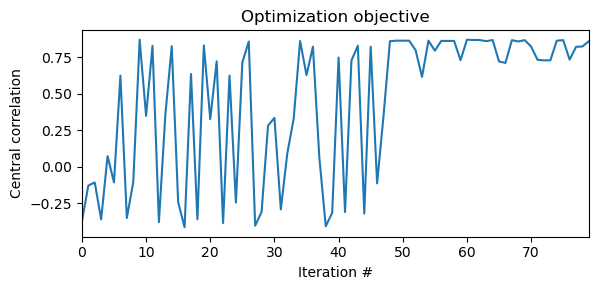

In [13]:
outputs.plot_optimization_objective();

### Visualize results

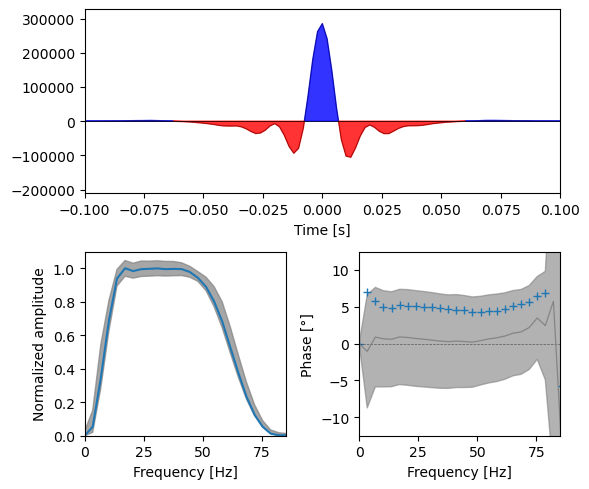

In [14]:
fig, axes = outputs.plot_wavelet(fmax=85, phi_max=15, figsize=(6,5))
axes[0].set_xlim((-0.1,0.1))
axes[2].set_ylim((-12.5,12.5))
fig.tight_layout()

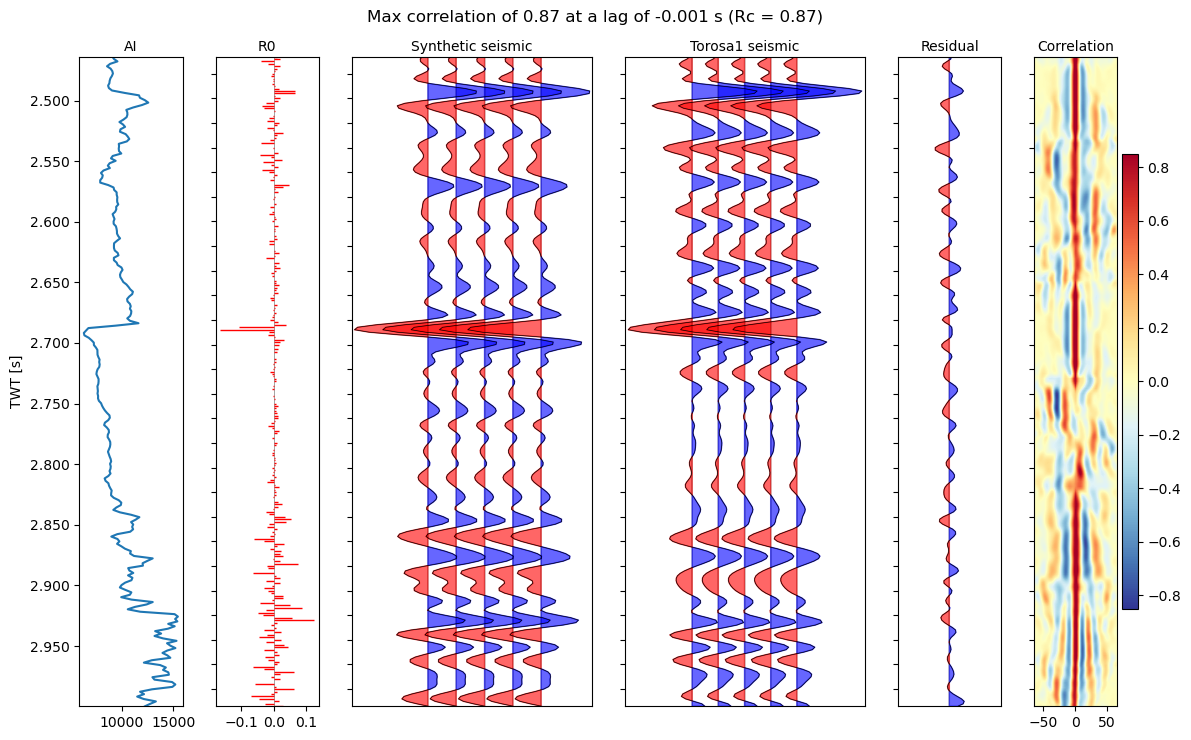

In [15]:
_scale = 120000
fig, axes = outputs.plot_tie_window(wiggle_scale=_scale, figsize=(12.,7.5))

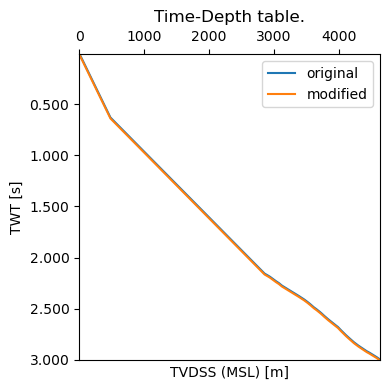

In [16]:
fig,ax = viz.plot_td_table(inputs.table, plot_params=dict(label='original'))
viz.plot_td_table(outputs.table,  plot_params=dict(label='modified'), fig_axes=(fig,ax))
ax.legend(loc='best')

#### Test automatic Stretch & Squeeze

In [17]:
s_and_s_params = dict(window_length=0.060, max_lag=0.010) # in seconds

outputs2 = autotie.stretch_and_squeeze(inputs,
                                       outputs,
                                       wavelet_extractor,
                                       modeler,
                                       wavelet_scaling_params,
                                       best_parameters,
                                       s_and_s_params)

Find wavelet absolute scale


  0%|          | 0/60 [00:00<?, ?it/s][WARNING 10-04 15:51:07] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:51:07] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:51:07] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f417e6757d0> (type: <class 'ax.core.data.Data'>).
[WARNING 10-04

[WARNING 10-04 15:51:08] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:51:08] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f417e61e590> (type: <class 'ax.core.data.Data'>).
[WARNING 10-04 15:51:08] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:51:08] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-04 15:51:08] ax.util

[WARNING 10-04 15:51:08] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f417e5c00d0> (type: <class 'ax.core.data.Data'>).
 15%|█▌        | 9/60 [00:00<00:06,  7.98it/s][WARNING 10-04 15:51:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:51:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-04 15:51:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 9 (type: <class 'int'>).
[WARNING 10-04 15:51:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator

 22%|██▏       | 13/60 [00:01<00:08,  5.67it/s][WARNING 10-04 15:51:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:51:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-04 15:51:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 13 (type: <class 'int'>).
[WARNING 10-04 15:51:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-04 15:51:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

[WARNING 10-04 15:51:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 10-04 15:51:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 17 (type: <class 'int'>).
[WARNING 10-04 15:51:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-04 15:51:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:51:10] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got 

[WARNING 10-04 15:51:11] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 21 (type: <class 'int'>).
[WARNING 10-04 15:51:11] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-04 15:51:11] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:51:11] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-

[WARNING 10-04 15:51:12] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 10-04 15:51:12] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:51:12] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:51:12] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got

[WARNING 10-04 15:51:14] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:51:14] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:51:14] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:51:14] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBrid

[WARNING 10-04 15:51:15] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:51:15] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:51:15] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f417e56d2d0> (type: <class 'ax.core.data.Data'>).
 57%|█████▋    | 34/60 [00:07<00:08,  2.94it/s][WARN

[WARNING 10-04 15:51:17] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:51:17] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x7f417e62c550> (type: <class 'ax.core.data.Data'>).
 63%|██████▎   | 38/60 [00:09<00:09,  2.34it/s][WARNING 10-04 15:51:17] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 10-04 15:51:17] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <c

 75%|███████▌  | 45/60 [00:23<00:28,  1.92s/it][WARNING 10-04 15:51:31] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:51:31] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:51:31] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type <class 'ax.core.data.Data'>. Got <ax.core.data.Data object at 0x7f417f6a0a50> (type: <class 'ax.core.data.Data'>).
 77%|███████▋  | 46/60 [00:25<00:29,  2

[WARNING 10-04 15:51:52] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `data` to be of type <class 'ax.core.data.Data'>. Got <ax.core.data.Data object at 0x7f417e5a6d90> (type: <class 'ax.core.data.Data'>).
 90%|█████████ | 54/60 [00:46<00:15,  2.51s/it][WARNING 10-04 15:51:54] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 10-04 15:51:54] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 10-04 15:51:54] ax.utils.commo

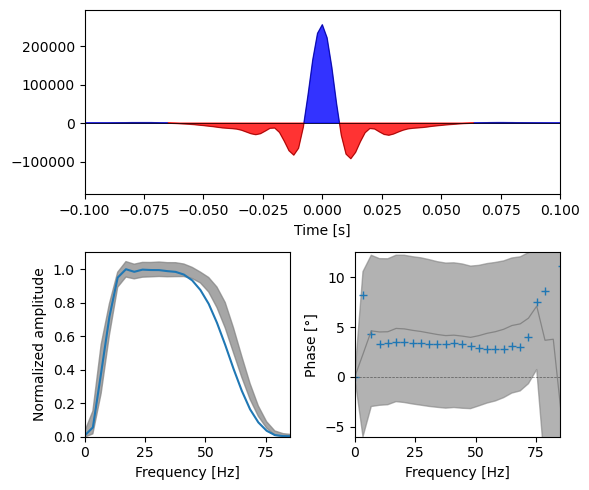

In [18]:
fig, axes = outputs2.plot_wavelet(fmax=85, phi_max=25, figsize=(6,5))
axes[0].set_xlim((-0.1,0.1))
axes[2].set_ylim((-6.,12.5))
fig.tight_layout()

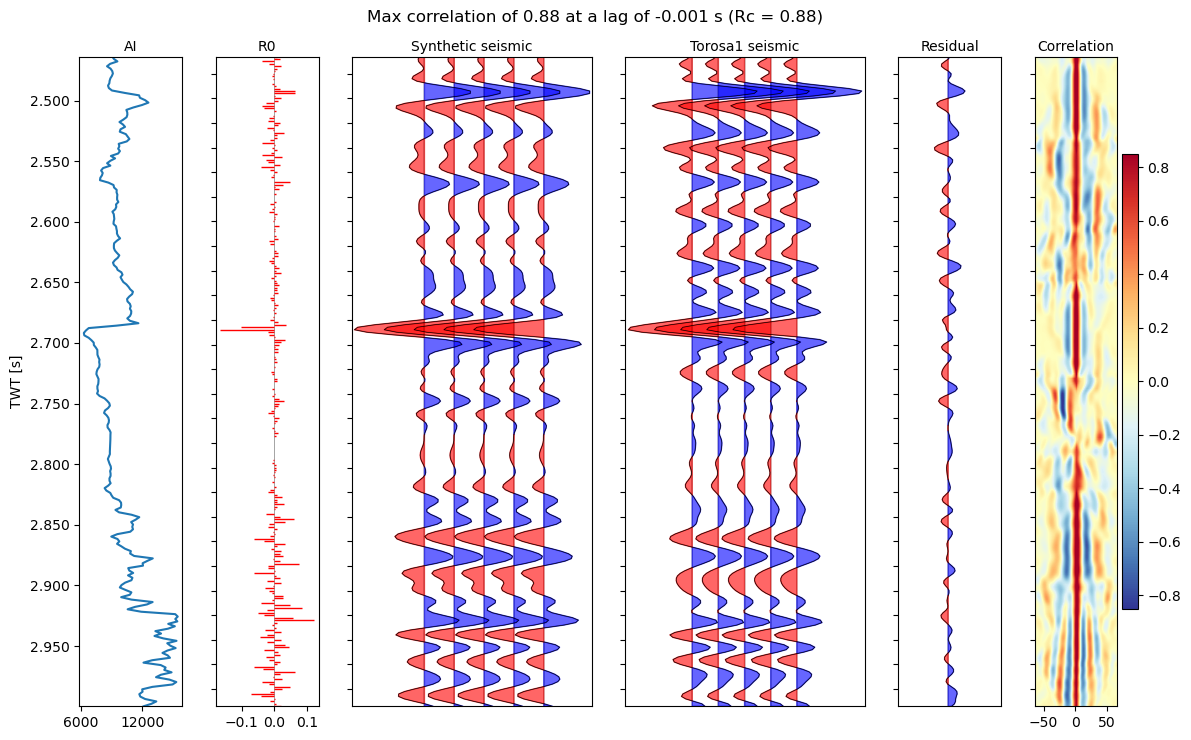

In [19]:
fig, axes = outputs2.plot_tie_window(wiggle_scale=_scale, figsize=(12.,7.5));
from matplotlib.ticker import MaxNLocator
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=2))

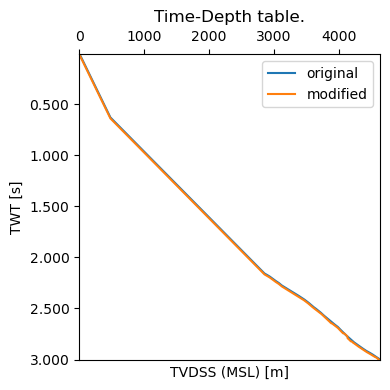

In [20]:
fig,ax = viz.plot_td_table(inputs.table, plot_params=dict(label='original'))
viz.plot_td_table(outputs2.table,  plot_params=dict(label='modified'), fig_axes=(fig,ax))
ax.legend(loc='best')

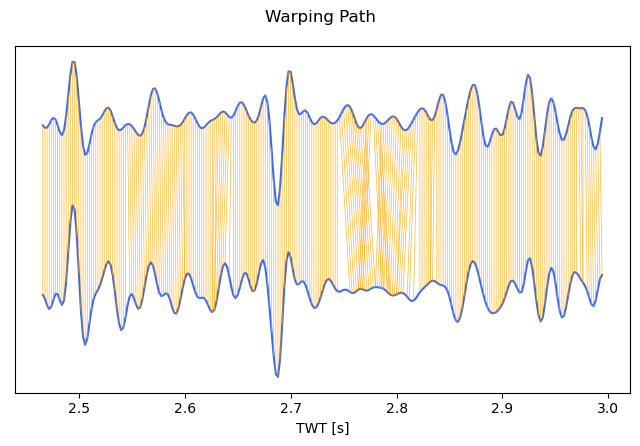

In [21]:
fig, ax = viz.plot_warping(outputs.synth_seismic, outputs.seismic, outputs2.dlags)